# Dataset Exploration using fiftyOne

In [1]:
import fiftyone as fo
import os
import glob

Convert from npy to pcd for visualization.

In [2]:
import fiftyone as fo
import numpy as np
import open3d as o3d
import os
import glob

LIDAR_TYPE = ".pcd"
IMAGE_TYPE = ".png"

for label in ["cubes", "spheres"]:
    npy_folder = f"../data/assessment/{label}/lidar_npy/"
    pcd_output_folder = f"../data/assessment/{label}/lidar_{LIDAR_TYPE}/" 

    os.makedirs(pcd_output_folder, exist_ok=True)
    npy_files = glob.glob(os.path.join(npy_folder, "*.npy"))
    samples = []

    print(f"Found {len(npy_files)} .npy files. Converting...")

    for npy_path in npy_files:
        points = np.load(npy_path)
        
        # Reshape to (N, 3) format for point cloud
        # Assuming the data is a depth map or similar
        if points.ndim == 2:
            h, w = points.shape
            y_coords, x_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
            points_3d = np.stack([x_coords.flatten(), y_coords.flatten(), points.flatten()], axis=1)
        else:
            points_3d = points.reshape(-1, 3)
        
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points_3d)
        
        base_name = os.path.splitext(os.path.basename(npy_path))[0]
        pcd_path = os.path.join(pcd_output_folder, f"{base_name}{LIDAR_TYPE}")
        o3d.io.write_point_cloud(pcd_path, pcd)
        
        sample = fo.Sample(filepath=pcd_path)
        samples.append(sample)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Found 9999 .npy files. Converting...
Found 10029 .npy files. Converting...


As the dataset contains many more cubes than spheres we will split both shapes individually with a 80/20 train/validation split to ensure we do not assign almost all spheres to the validation set, which would risk our model never learning (well) what a sphere looks like.

In [ ]:
import fiftyone.utils.random as fo_rng

if "cilp_assessment" in fo.list_datasets():
    fo.delete_dataset("cilp_assessment")

dataset = fo.Dataset("cilp_assessment")

dataset.add_group_field("group", default="rgb")

data_root = "../data/assessment"
classes = ["cubes", "spheres"]
training_fraction = 0.8

samples = []

rgb_width   =   None
rgb_height  =   None
for class_label in classes:
    rgb_paths = glob.glob(os.path.join(data_root, class_label, "rgb", "*"))
    #ASSUMPTION: Each RGB file has a corresponding LiDAR file with the same base name in the "lidar_pcd" folder vice versa.
    for rgb_path in rgb_paths:
        filename =      os.path.basename(rgb_path)
        base_name =     os.path.splitext(filename)[0]
        #fetch corresponding lidar file (could be potentially optimized by doing one sequential read, but for our dataset size it does not matter)
        lidar_path =    os.path.join(data_root, class_label, "lidar_pcd", base_name + ".pcd") 
        
        group = fo.Group()

        rgb_sample = fo.Sample(filepath=rgb_path, group=group.element("rgb"))
        rgb_sample["ground_truth"] = fo.Classification(label=class_label)
        if rgb_height is None:
            rgb_sample.compute_metadata()
            print("rgb image dimensions are H: ", rgb_sample.metadata.height, " W: ", rgb_sample.metadata.width)
            rgb_height = rgb_sample.metadata.height
            rgb_width = rgb_sample.metadata.width
        
        lidar_sample = fo.Sample(filepath=lidar_path, group=group.element("lidar"))
        lidar_sample["ground_truth"] = fo.Classification(label=class_label)
        
        samples.extend([rgb_sample, lidar_sample])

dataset.add_samples(samples)
fo_rng.random_split(dataset.select_group_slices("rgb"), {"train": training_fraction, "val": 1-training_fraction}, seed=42)
fo_rng.random_split(dataset.select_group_slices("lidar"), {"train": training_fraction, "val": 1-training_fraction}, seed=42)
dataset.save()

print(f"Dataset created with {len(dataset)} samples and slices {dataset.group_slices} with types {IMAGE_TYPE} and {LIDAR_TYPE}.")
print(f"Dataset split: {training_fraction} train, {1-training_fraction} validation, split groupwise.")

rgb image dimensions are H:  64  W:  64
 100% |█████████████| 21502/21502 [5.2s elapsed, 0s remaining, 4.0K samples/s]      
Dataset created with 10751 samples and slices ['rgb', 'lidar'] with types .png and .pcd.
Dataset split: 80% train, 19% validation, split groupwise.


<BarContainer object of 2 artists>

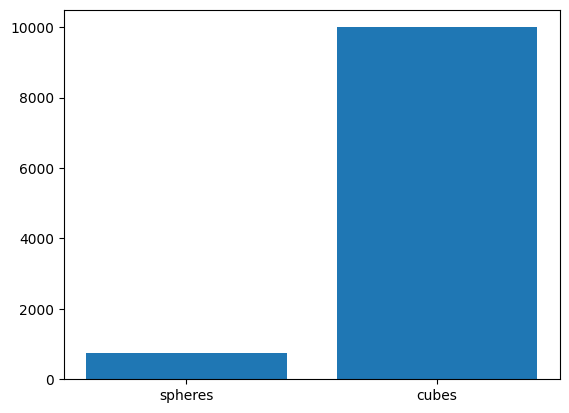

In [62]:
import matplotlib.pyplot as plt
from fiftyone import ViewField as F

cubes_samples =     len(dataset.match(F("ground_truth.label") == "cubes"))
spheres_samples =   len(dataset.match(F("ground_truth.label") == "spheres"))

plt.bar(["spheres", "cubes"], [spheres_samples, cubes_samples])

In [5]:
fo.launch_app(dataset)

Dataset:         cilp_assessment
Media type:      group
Num groups:      10751
Selected groups: 0
Selected labels: 0
Session URL:     http://localhost:5151/